In [5]:
import pandas as pd  
import numpy as np 
import io
import os

# Sagemaker Python SDK
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker import get_execution_role
import boto3


import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [81]:
role = get_execution_role
input_bucket = 'wwcteammarywilkeslillian'
in_data_key = 'combined_male_female.csv'
training_data_location = 's3://{}/{}'.format(input_bucket, in_data_key)
df = pd.read_csv(training_data_location, index_col = 0)
print('uploaded training data from location: {}'.format(training_data_location))

uploaded training data from location: s3://wwcteammarywilkeslillian/combined_male_female.csv


# DATA VISUALIZATION AND STATISTICS

In [82]:
#inspect the data
df.head()


,COUNTY,AGE,GENDER,MONTH,DAY,OUTCOME
0,Alachua,21,Female,3,17,Case
1,Alachua,50,Female,3,18,Case
2,Alachua,39,Female,3,18,Case
3,Alachua,42,Female,3,19,Case
4,Alachua,27,Female,3,19,Case


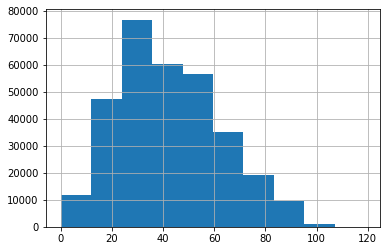

In [11]:
df.AGE.hist()

In [12]:
df.shape

(317756, 6)

In [13]:
df['AGE'].describe()

count    317756.000000
mean         42.341183
std          20.117551
min           0.000000
25%          27.000000
50%          40.000000
75%          56.000000
max         119.000000
Name: AGE, dtype: float64

In [15]:
county_outcome = pd.crosstab(df.COUNTY,df.OUTCOME)
county_outcome

OUTCOME,Case,Death
COUNTY,,
Alachua,2392,12
Baker,200,4
Bay,1598,8
Bradford,173,2
Brevard,3786,44
...,...,...
Unknown,357,0
Volusia,4545,79
Wakulla,222,1


,AGE
count,160076.000000
mean,42.000981
std,20.152448
min,0.000000
25%,26.000000
50%,39.000000
75%,56.000000
max,119.000000


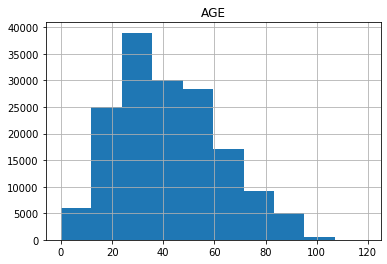

In [49]:
#extract female cases 
#first extract gender, outcome, age
gender_outcome_df = df[["GENDER", "OUTCOME", "AGE"]]
#then extract rows where GENDER == "Female" and OUTCOME == 'Case'
female_cases_df = gender_outcome_df.loc[(gender_outcome_df['GENDER'] == 'Female') & (gender_outcome_df['OUTCOME'] == 'Case')]
female_cases_df.hist()
female_cases_df.shape
female_cases_df.head()
female_cases_df.describe()







,AGE
count,2126.000000
mean,79.544214
std,13.660925
min,11.000000
25%,72.000000
50%,82.000000
75%,89.000000
max,108.000000


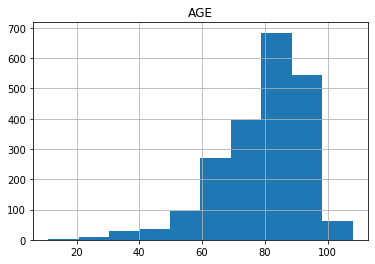

In [52]:
#extract female deaths 
#first extract gender, outcome, age
gender_outcome_df = df[["GENDER", "OUTCOME", "AGE"]]
#then extract rows where GENDER == "Female" and OUTCOME == 'Death'
female_deaths_df = gender_outcome_df.loc[(gender_outcome_df['GENDER'] == 'Female') & (gender_outcome_df['OUTCOME'] == 'Death')]
female_deaths_df.hist()
female_deaths_df.shape
female_deaths_df.head()
female_deaths_df.describe()

,AGE
count,153012.000000
mean,41.639832
std,19.295694
min,0.000000
25%,27.000000
50%,39.000000
75%,55.000000
max,105.000000


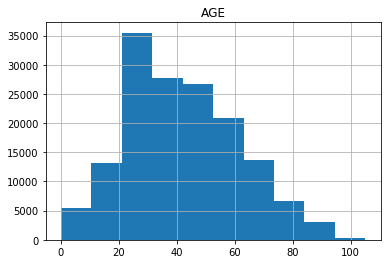

In [51]:
#extract male cases 
#first extract gender, outcome, age
gender_outcome_df = df[["GENDER", "OUTCOME", "AGE"]]
#then extract rows where GENDER == "Female" and OUTCOME == 'Case'
male_cases_df = gender_outcome_df.loc[(gender_outcome_df['GENDER'] == 'Male') & (gender_outcome_df['OUTCOME'] == 'Case')]
male_cases_df.hist()
male_cases_df.shape
male_cases_df.head()
male_cases_df.describe()

,AGE
count,2542.000000
mean,74.866640
std,14.012444
min,11.000000
25%,67.000000
50%,77.000000
75%,85.000000
max,103.000000


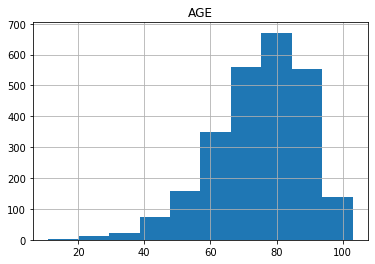

In [53]:
#extract male deaths 
#first extract gender, outcome, age
gender_outcome_df = df[["GENDER", "OUTCOME", "AGE"]]
#then extract rows where GENDER == "Male" and OUTCOME == 'Death'
male_deaths_df = gender_outcome_df.loc[(gender_outcome_df['GENDER'] == 'Male') & (gender_outcome_df['OUTCOME'] == 'Death')]
male_deaths_df.hist()
male_deaths_df.shape
male_deaths_df.head()
male_deaths_df.describe()

In [61]:
#independent sample t-test to check if means between ages of female cases and male cases are significantly different
# The larger the t score, the more difference there is between groups. 
# The smaller the t score, the more similarity there is between groups. 
# A p score of 0.05 indicates a low probability that the differences occured by chance.
# Here the results indicate no significant difference between ages of  male and female cases
from scipy.stats import ttest_ind

cat1 = female_cases_df['AGE']
cat2 = male_cases_df['AGE']
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=5.117608124970047, pvalue=3.096169521521241e-07)

In [62]:
# Independent sample t-test to check if means between ages of female deaths and male deaths are signficantly different.
# Here the results indicate no significant differences between ages of male and female deaths
cat1 = female_deaths_df['AGE']
cat2 = male_deaths_df['AGE']
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=11.48858052180795, pvalue=3.8162701490960634e-30)

In [63]:
# Independent sample t-test to check if means between ages of female deaths and female cases are signficantly different.
# Here the results indicate a significant difference between ages of female cases and female deaths
cat1 = female_cases_df['AGE']
cat2 = female_deaths_df['AGE']
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=-85.63741927331526, pvalue=0.0)

In [64]:
# Independent sample t-test to check if means between ages of male deaths and male cases are signficantly different.
# Here the results indicate a significant difference between ages of female cases and female deaths
cat1 = male_cases_df['AGE']
cat2 = male_deaths_df['AGE']
ttest_ind(cat1, cat2)

Ttest_indResult(statistic=-86.44128044574916, pvalue=0.0)

In [65]:
#check for null values (There aren't any null values)
df.isnull().sum()

COUNTY     0
AGE        0
GENDER     0
MONTH      0
DAY        0
OUTCOME    0
dtype: int64

In [66]:
#check the data types (Gender and County need to be converted to numbers)
df.dtypes

COUNTY     object
AGE         int64
GENDER     object
MONTH       int64
DAY         int64
OUTCOME    object
dtype: object

In [67]:
#more info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317756 entries, 0 to 317755
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   COUNTY   317756 non-null  object
 1   AGE      317756 non-null  int64 
 2   GENDER   317756 non-null  object
 3   MONTH    317756 non-null  int64 
 4   DAY      317756 non-null  int64 
 5   OUTCOME  317756 non-null  object
dtypes: int64(3), object(3)
memory usage: 27.0+ MB


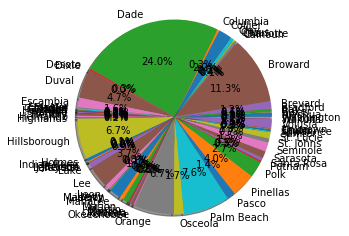

In [68]:
#More data visualizaton. This pie chart shows the count of all records by county.  
#Dade, Broward, Palm Beach and Orange counties have the top three the most records.
labels = df['COUNTY'].astype('category').cat.categories.tolist()
counts = df['COUNTY'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

In [89]:
#Cast object type to category type (increases processing speed, reduces memory usage, and needed by encoding step)
df = df.astype({"COUNTY":'category', "OUTCOME":'category', "GENDER": 'category', "AGE": 'category', "MONTH": 'category', "DAY": 'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317756 entries, 0 to 317755
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   COUNTY   317756 non-null  category
 1   AGE      317756 non-null  category
 2   GENDER   317756 non-null  category
 3   MONTH    317756 non-null  category
 4   DAY      317756 non-null  category
 5   OUTCOME  317756 non-null  category
dtypes: category(6)
memory usage: 4.3 MB


# DATA ENCODING
#### A new dataframe is encoded so that the original data is not changed.

In [96]:
#convert category data type to encoded columns
#GENDER and OUTCOME
df_encoded = pd.get_dummies(df[['GENDER', 'OUTCOME', 'COUNTY', 'AGE', 'MONTH', 'DAY']], drop_first=True, sparse = True)
#Add a bias so that any model is not confined to passing through the origin
df_encoded['BIAS'] = np.ones(df_encoded.shape[0])
df_encoded.head()
df_encoded.tail()


,GENDER_Male,OUTCOME_Death,COUNTY_Baker,COUNTY_Bay,COUNTY_Bradford,COUNTY_Brevard,COUNTY_Broward,COUNTY_Calhoun,COUNTY_Charlotte,COUNTY_Citrus,...,DAY_23,DAY_24,DAY_25,DAY_26,DAY_27,DAY_28,DAY_29,DAY_30,DAY_31,BIAS
317751,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1.0
317752,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1.0
317753,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1.0
317754,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1.0
317755,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0


### NOTE:  WHEN ENCODING CATEGORY DATA, A COLUMN FOR EACH CATEGORY WAS DROPPED.
#### IT MAY BE NECESSARY TO DROP COLUMNS WHEN ENCODING FOR MULTIPLE LINEAR REGRESSION MODELLING.
#### ALSO:  DAY AND MONTH ARE CYCLICAL VALUES AND MAY NEED TO BE REPLACED WITH SIN AND COSINE VALUES
#### ALSO:  AGE IS NUMERICAL IMPLYING AN ORDINAL RELATIONSHIP.  HOWEVER, IN THIS USE CASE, AGE IS NOMINAL AND WAS ENCODED.

In [ ]:
#shuffle the data
#split into training and testing sets
#run multiple linear regression model
#assess model
